In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
from tqdm.auto import tqdm



D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, is_train=True, fraction=1.0):
        """
        Initializes the SegmentationDataset.

        Parameters:
            images_dir (str): Path to the directory containing the images.
            masks_dir (str): Path to the directory containing the masks.
            is_train (bool): If True, apply data augmentation; if False, only basic preprocessing.
            fraction (float): The fraction of the dataset to use. Default is 1.0 (use the entire dataset).
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = os.listdir(images_dir)

        # Apply fraction if less than 1
        if 0 < fraction < 1:
            subset_size = int(len(self.images) * fraction)
            self.images = random.sample(self.images, subset_size)
        
        # Set up transforms
        self.transform, self.mask_transform = self.get_transforms(is_train)

    def get_transforms(self, is_train):
        """
        Get the transform and mask transform based on whether data augmentation is needed.

        Parameters:
            is_train (bool): Whether to apply data augmentation.

        Returns:
            (tuple): A tuple containing the image and mask transforms.
        """
        if is_train:
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])

        # Mask transform with nearest-neighbor interpolation
        mask_transform = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST),
            transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long)),
        ])

        return transform, mask_transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        
        # Extract file extension to find corresponding mask
        image_extension = os.path.splitext(self.images[idx])[1]
        mask_name = os.path.join(self.masks_dir, self.images[idx].replace(image_extension, '.png'))
        mask = Image.open(mask_name).convert("L")

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask.squeeze(0)

In [4]:
# Load and split datasets


train_path = 'deeplabv3/train'
val_path = 'deeplabv3/val/'
test_path = 'deeplabv3/test/'

train_mask_path = 'deeplabv3/masks/train'
val_mask_path = 'deeplabv3/masks/val/'
test_mask_path = 'deeplabv3/masks/test/'


# 加载数据集
# 划分数据集为训练集和测试集
train_dataset = SegmentationDataset(train_path, train_mask_path,is_train=True, fraction=0.6)
val_dataset = SegmentationDataset(val_path, val_mask_path, is_train=False, fraction=0.6)
test_dataset = SegmentationDataset(test_path, test_mask_path, is_train=False, fraction=0.6)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)  # Batch size increased
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,  pin_memory=True)

# Load and modify DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
num_classes = 4  # 0background 1carapace 2flipper 3head
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Improved class weights to better handle class imbalance
# weights = torch.tensor([0.2, 1.0, 2.5, 4.0], dtype=torch.float32).to(device)  # Adjusted class weights
weights = torch.tensor([0.2, 1.0, 2.0, 2.5], dtype=torch.float32).to(device)  # Adjusted class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Use AdamW optimizer for better regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler for dynamic adjustment
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)



D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def calculate_metrics(predictions, masks, num_classes):
    metrics = {
        'iou': np.zeros(num_classes),
        'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
    }

    # Calculate IoU per class
    for cls in range(num_classes):
        pred_mask = (predictions == cls).astype(np.uint8)
        true_mask = (masks == cls).astype(np.uint8)
        
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        
        if union > 0:
            metrics['iou'][cls] = intersection / union  # IoU for each class

    metrics['confusion_matrix'] = confusion_matrix(masks.flatten(), predictions.flatten(), labels=range(num_classes))
    return metrics


def model_eval(model, val_loader, num_classes, output_path='out'):
    model.eval()
    os.makedirs(output_path, exist_ok=True)
    
    # Initialize arrays to store cumulative metrics across all images in the validation set
    all_metrics = {
        'iou': [],
        'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
    }

    # Evaluate model without computing gradients
    with torch.no_grad():
        for images, masks in val_loader:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass to get predictions
            outputs = model(images)['out']
            predictions = outputs.argmax(dim=1).cpu().numpy()
            true_masks = masks.cpu().numpy()

            # Calculate metrics for each image in the batch
            for pred, true_mask in zip(predictions, true_masks):
                metrics = calculate_metrics(pred, true_mask, num_classes)
                all_metrics['iou'].append(metrics['iou'])
                all_metrics['confusion_matrix'] += metrics['confusion_matrix']

    # Calculate IoU for each class and the mean IoU
    iou_array = np.vstack(all_metrics['iou'])
    mean_iou_per_class = np.nanmean(iou_array[:, 1:], axis=0)
    overall_mean_iou = np.nanmean(mean_iou_per_class)
    confusion_matrix_total = all_metrics['confusion_matrix']

    # Plot IoU per Class and Overall Mean IoU (excluding background)
    class_labels = ["Carapace", "Flippers", "Head"]
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels + ["Mean IoU"], np.append(mean_iou_per_class, overall_mean_iou), color='lightblue')
    plt.ylim(0, 1)
    plt.ylabel("IoU")
    plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")
    for i, v in enumerate(np.append(mean_iou_per_class, overall_mean_iou)):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    plt.savefig(os.path.join(output_path, "iou_per_class.png"))
    plt.close()

    # Normalize the confusion matrix
    normalized_confusion_matrix = confusion_matrix_total.astype('float') / confusion_matrix_total.sum(axis=1, keepdims=True)

    # Plot normalized confusion matrix
    all_class_labels = ["Background", "Carapace", "Flippers", "Head"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=all_class_labels, yticklabels=all_class_labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Normalized Confusion Matrix")
    plt.savefig(os.path.join(output_path, "normalized_confusion_matrix.png"))
    plt.close()


    

In [5]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    with tqdm(train_loader, desc=f"Epoch/{num_epochs}]") as progress_bar:
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            # Forward pass
            outputs = model(images)['out']
            
            loss = criterion(outputs, masks.long())
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")
    # Scheduler step
    scheduler.step()
    
torch.save(model.state_dict(), f'{deeplavb3_path}ep{num_epochs}.pth')
print("Training complete.")

Epoch/15]:   0%|          | 1/398 [00:01<11:24,  1.72s/it]

Epoch [1/15], Loss: 1.4551


Epoch/15]:   1%|          | 2/398 [00:02<07:06,  1.08s/it]

Epoch [1/15], Loss: 1.2948


Epoch/15]:   1%|          | 3/398 [00:03<05:50,  1.13it/s]

Epoch [1/15], Loss: 1.2751


Epoch/15]:   1%|          | 4/398 [00:03<05:06,  1.29it/s]

Epoch [1/15], Loss: 1.2144


Epoch/15]:   1%|▏         | 5/398 [00:04<04:47,  1.37it/s]

Epoch [1/15], Loss: 1.0865


Epoch/15]:   2%|▏         | 6/398 [00:04<04:30,  1.45it/s]

Epoch [1/15], Loss: 0.9648


Epoch/15]:   2%|▏         | 7/398 [00:05<04:23,  1.48it/s]

Epoch [1/15], Loss: 0.9793


Epoch/15]:   2%|▏         | 8/398 [00:06<04:15,  1.53it/s]

Epoch [1/15], Loss: 0.9685


Epoch/15]:   2%|▏         | 9/398 [00:06<04:04,  1.59it/s]

Epoch [1/15], Loss: 0.9495


Epoch/15]:   3%|▎         | 10/398 [00:07<04:00,  1.61it/s]

Epoch [1/15], Loss: 0.9400


Epoch/15]:   3%|▎         | 11/398 [00:07<03:53,  1.65it/s]

Epoch [1/15], Loss: 0.8947


Epoch/15]:   3%|▎         | 12/398 [00:08<03:52,  1.66it/s]

Epoch [1/15], Loss: 0.7506


Epoch/15]:   3%|▎         | 13/398 [00:09<03:51,  1.67it/s]

Epoch [1/15], Loss: 0.8076


Epoch/15]:   4%|▎         | 14/398 [00:09<03:51,  1.66it/s]

Epoch [1/15], Loss: 0.7869


Epoch/15]:   4%|▍         | 15/398 [00:10<03:54,  1.63it/s]

Epoch [1/15], Loss: 0.6599


Epoch/15]:   4%|▍         | 16/398 [00:10<03:47,  1.68it/s]

Epoch [1/15], Loss: 0.7981


Epoch/15]:   4%|▍         | 17/398 [00:11<03:50,  1.65it/s]

Epoch [1/15], Loss: 0.6995


Epoch/15]:   5%|▍         | 18/398 [00:12<03:52,  1.64it/s]

Epoch [1/15], Loss: 0.7084


Epoch/15]:   5%|▍         | 19/398 [00:12<03:47,  1.67it/s]

Epoch [1/15], Loss: 0.6922


Epoch/15]:   5%|▌         | 20/398 [00:13<03:55,  1.61it/s]

Epoch [1/15], Loss: 0.7490


Epoch/15]:   5%|▌         | 21/398 [00:13<03:54,  1.61it/s]

Epoch [1/15], Loss: 0.6056


Epoch/15]:   6%|▌         | 22/398 [00:14<03:49,  1.64it/s]

Epoch [1/15], Loss: 0.7918


Epoch/15]:   6%|▌         | 23/398 [00:15<03:49,  1.64it/s]

Epoch [1/15], Loss: 0.7807


Epoch/15]:   6%|▌         | 24/398 [00:15<03:46,  1.65it/s]

Epoch [1/15], Loss: 0.6058


Epoch/15]:   6%|▋         | 25/398 [00:16<03:46,  1.65it/s]

Epoch [1/15], Loss: 0.5833


Epoch/15]:   7%|▋         | 26/398 [00:16<03:44,  1.66it/s]

Epoch [1/15], Loss: 0.7550


Epoch/15]:   7%|▋         | 27/398 [00:17<03:41,  1.68it/s]

Epoch [1/15], Loss: 0.4872


Epoch/15]:   7%|▋         | 28/398 [00:18<03:42,  1.66it/s]

Epoch [1/15], Loss: 0.6706


Epoch/15]:   7%|▋         | 29/398 [00:18<03:38,  1.69it/s]

Epoch [1/15], Loss: 0.5344


Epoch/15]:   8%|▊         | 30/398 [00:19<03:37,  1.70it/s]

Epoch [1/15], Loss: 0.5001


Epoch/15]:   8%|▊         | 31/398 [00:19<03:38,  1.68it/s]

Epoch [1/15], Loss: 0.4989


Epoch/15]:   8%|▊         | 32/398 [00:20<03:35,  1.70it/s]

Epoch [1/15], Loss: 0.4414


Epoch/15]:   8%|▊         | 33/398 [00:21<03:35,  1.69it/s]

Epoch [1/15], Loss: 0.6348


Epoch/15]:   9%|▊         | 34/398 [00:21<03:30,  1.73it/s]

Epoch [1/15], Loss: 0.5978


Epoch/15]:   9%|▉         | 35/398 [00:22<03:33,  1.70it/s]

Epoch [1/15], Loss: 0.3743


Epoch/15]:   9%|▉         | 36/398 [00:22<03:33,  1.70it/s]

Epoch [1/15], Loss: 0.9562


Epoch/15]:   9%|▉         | 37/398 [00:23<03:40,  1.63it/s]

Epoch [1/15], Loss: 0.7663


Epoch/15]:  10%|▉         | 38/398 [00:24<03:36,  1.66it/s]

Epoch [1/15], Loss: 0.4769


Epoch/15]:  10%|▉         | 39/398 [00:24<03:34,  1.67it/s]

Epoch [1/15], Loss: 0.6072


Epoch/15]:  10%|█         | 40/398 [00:25<03:31,  1.69it/s]

Epoch [1/15], Loss: 0.5177


Epoch/15]:  10%|█         | 41/398 [00:25<03:32,  1.68it/s]

Epoch [1/15], Loss: 0.4749


Epoch/15]:  11%|█         | 42/398 [00:26<03:32,  1.68it/s]

Epoch [1/15], Loss: 0.4808


Epoch/15]:  11%|█         | 43/398 [00:27<03:31,  1.68it/s]

Epoch [1/15], Loss: 0.4830


Epoch/15]:  11%|█         | 44/398 [00:27<03:32,  1.66it/s]

Epoch [1/15], Loss: 0.7911


Epoch/15]:  11%|█▏        | 45/398 [00:28<03:32,  1.66it/s]

Epoch [1/15], Loss: 0.5915


Epoch/15]:  12%|█▏        | 46/398 [00:28<03:31,  1.66it/s]

Epoch [1/15], Loss: 0.5166


Epoch/15]:  12%|█▏        | 47/398 [00:29<03:28,  1.68it/s]

Epoch [1/15], Loss: 0.5521


Epoch/15]:  12%|█▏        | 48/398 [00:30<03:28,  1.68it/s]

Epoch [1/15], Loss: 0.5187


Epoch/15]:  12%|█▏        | 49/398 [00:30<03:29,  1.67it/s]

Epoch [1/15], Loss: 0.5842


Epoch/15]:  13%|█▎        | 50/398 [00:31<03:30,  1.65it/s]

Epoch [1/15], Loss: 0.6170


Epoch/15]:  13%|█▎        | 51/398 [00:31<03:30,  1.65it/s]

Epoch [1/15], Loss: 0.7162


Epoch/15]:  13%|█▎        | 52/398 [00:32<03:30,  1.64it/s]

Epoch [1/15], Loss: 0.5011


Epoch/15]:  13%|█▎        | 53/398 [00:33<03:24,  1.69it/s]

Epoch [1/15], Loss: 0.4384


Epoch/15]:  14%|█▎        | 54/398 [00:33<03:23,  1.69it/s]

Epoch [1/15], Loss: 0.4700


Epoch/15]:  14%|█▍        | 55/398 [00:34<03:27,  1.65it/s]

Epoch [1/15], Loss: 0.5666


Epoch/15]:  14%|█▍        | 56/398 [00:34<03:26,  1.65it/s]

Epoch [1/15], Loss: 0.3886


Epoch/15]:  14%|█▍        | 57/398 [00:35<03:25,  1.66it/s]

Epoch [1/15], Loss: 0.8217


Epoch/15]:  15%|█▍        | 58/398 [00:36<03:23,  1.67it/s]

Epoch [1/15], Loss: 0.5624


Epoch/15]:  15%|█▍        | 59/398 [00:36<03:21,  1.68it/s]

Epoch [1/15], Loss: 0.3868


Epoch/15]:  15%|█▌        | 60/398 [00:37<03:16,  1.72it/s]

Epoch [1/15], Loss: 0.4947


Epoch/15]:  15%|█▌        | 61/398 [00:37<03:19,  1.69it/s]

Epoch [1/15], Loss: 0.4639


Epoch/15]:  16%|█▌        | 62/398 [00:38<03:22,  1.66it/s]

Epoch [1/15], Loss: 0.5334


Epoch/15]:  16%|█▌        | 63/398 [00:39<03:21,  1.66it/s]

Epoch [1/15], Loss: 0.5048


Epoch/15]:  16%|█▌        | 64/398 [00:39<03:25,  1.63it/s]

Epoch [1/15], Loss: 0.5550


Epoch/15]:  16%|█▋        | 65/398 [00:40<03:25,  1.62it/s]

Epoch [1/15], Loss: 0.5924


Epoch/15]:  17%|█▋        | 66/398 [00:40<03:24,  1.62it/s]

Epoch [1/15], Loss: 0.4050


Epoch/15]:  17%|█▋        | 67/398 [00:41<03:25,  1.61it/s]

Epoch [1/15], Loss: 0.4833


Epoch/15]:  17%|█▋        | 68/398 [00:42<03:20,  1.64it/s]

Epoch [1/15], Loss: 0.3598


Epoch/15]:  17%|█▋        | 69/398 [00:42<03:16,  1.67it/s]

Epoch [1/15], Loss: 0.6971


Epoch/15]:  18%|█▊        | 70/398 [00:43<03:19,  1.65it/s]

Epoch [1/15], Loss: 0.4300


Epoch/15]:  18%|█▊        | 71/398 [00:43<03:19,  1.64it/s]

Epoch [1/15], Loss: 0.6189


Epoch/15]:  18%|█▊        | 72/398 [00:44<03:19,  1.63it/s]

Epoch [1/15], Loss: 0.3782


Epoch/15]:  18%|█▊        | 73/398 [00:45<03:15,  1.66it/s]

Epoch [1/15], Loss: 0.2847


Epoch/15]:  19%|█▊        | 74/398 [00:45<03:14,  1.66it/s]

Epoch [1/15], Loss: 0.2836


Epoch/15]:  19%|█▉        | 75/398 [00:46<03:11,  1.68it/s]

Epoch [1/15], Loss: 0.4659


Epoch/15]:  19%|█▉        | 76/398 [00:46<03:12,  1.68it/s]

Epoch [1/15], Loss: 0.3690


Epoch/15]:  19%|█▉        | 77/398 [00:47<03:11,  1.67it/s]

Epoch [1/15], Loss: 0.3362


Epoch/15]:  20%|█▉        | 78/398 [00:48<03:12,  1.66it/s]

Epoch [1/15], Loss: 0.4669


Epoch/15]:  20%|█▉        | 79/398 [00:48<03:08,  1.69it/s]

Epoch [1/15], Loss: 0.3510


Epoch/15]:  20%|██        | 80/398 [00:49<03:08,  1.69it/s]

Epoch [1/15], Loss: 0.3613


Epoch/15]:  20%|██        | 81/398 [00:49<03:03,  1.72it/s]

Epoch [1/15], Loss: 0.3969


Epoch/15]:  21%|██        | 82/398 [00:50<03:02,  1.74it/s]

Epoch [1/15], Loss: 0.2549


Epoch/15]:  21%|██        | 83/398 [00:51<03:02,  1.72it/s]

Epoch [1/15], Loss: 0.3005


Epoch/15]:  21%|██        | 83/398 [00:51<03:14,  1.62it/s]


KeyboardInterrupt: 

In [14]:
#载入训练好的模型
model = torchvision.models.segmentation.__dict__["deeplabv3_resnet101"](aux_loss=False, num_classes=4)
checkpoint = torch.load('dv3_ep50.pth', map_location="cpu", weights_only=True)
model.load_state_dict({k: v for k, v in checkpoint.items() if 'aux_classifier' not in k}, strict=False)
model = model.to("cuda")  # Moves the model to the GPU

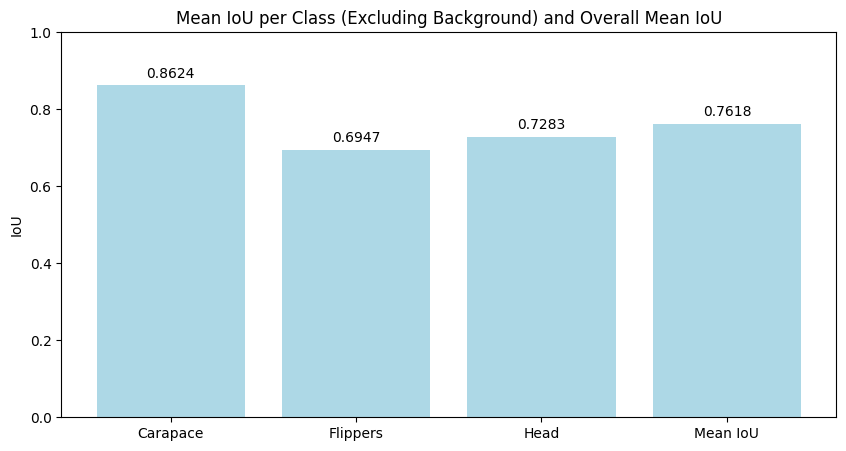

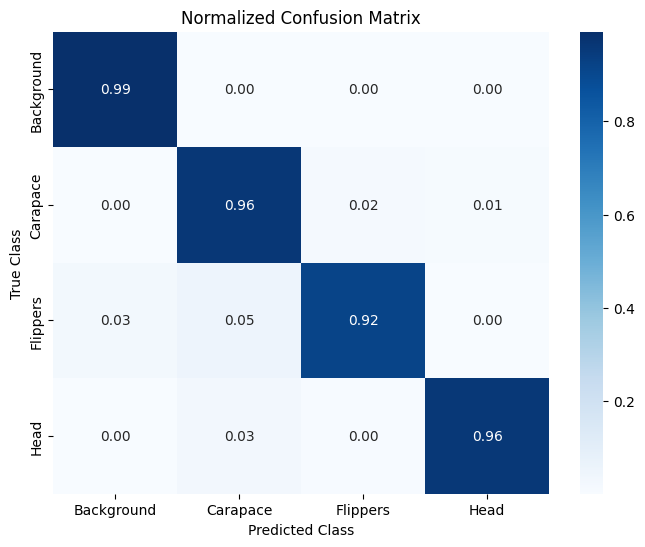

In [23]:
model.eval()
output_path = 'out'
os.makedirs(output_path, exist_ok=True)

# Initialize arrays to store cumulative metrics across all images in the validation set
all_metrics = {
    'iou': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
}

# Evaluate model without computing gradients
with torch.no_grad():
    for images, masks in val_loader:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Move images and masks to device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass to get predictions
        outputs = model(images)['out']
        predictions = outputs.argmax(dim=1).cpu().numpy()
        true_masks = masks.cpu().numpy()

        # Calculate metrics for each image in the batch
        for pred, true_mask in zip(predictions, true_masks):
            metrics = calculate_metrics(pred, true_mask, num_classes)
            all_metrics['iou'].append(metrics['iou'])
            all_metrics['confusion_matrix'] += metrics['confusion_matrix']

# Calculate IoU for each class and the mean IoU
iou_array = np.vstack(all_metrics['iou'])
mean_iou_per_class = np.nanmean(iou_array[:, 1:], axis=0)
overall_mean_iou = np.nanmean(mean_iou_per_class)
confusion_matrix_total = all_metrics['confusion_matrix']
# Plot IoU per Class and Overall Mean IoU (excluding background)
class_labels = ["Carapace", "Flippers", "Head"]
plt.figure(figsize=(10, 5))
plt.bar(class_labels + ["Mean IoU"], np.append(mean_iou_per_class, overall_mean_iou), color='lightblue')
plt.ylim(0, 1)
plt.ylabel("IoU")
plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")
for i, v in enumerate(np.append(mean_iou_per_class, overall_mean_iou)):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.savefig(os.path.join(output_path, "iou_per_class.png"))
plt.show()
plt.close()
# Normalize the confusion matrix
normalized_confusion_matrix = confusion_matrix_total.astype('float') / confusion_matrix_total.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
all_class_labels = ["Background", "Carapace", "Flippers", "Head"]
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=all_class_labels, yticklabels=all_class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.savefig(os.path.join(output_path, "normalized_confusion_matrix.png"))
plt.show()

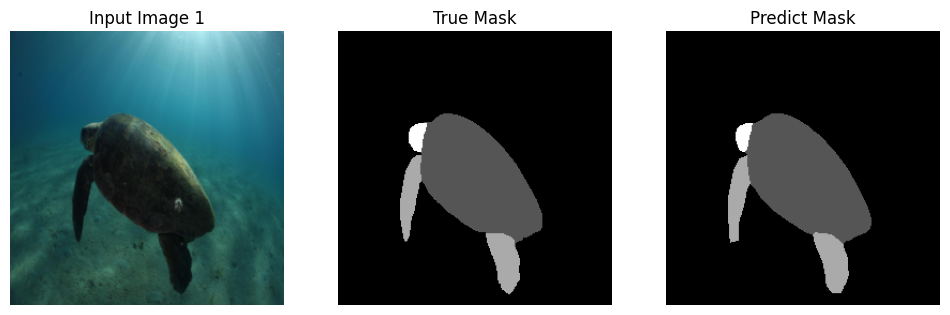

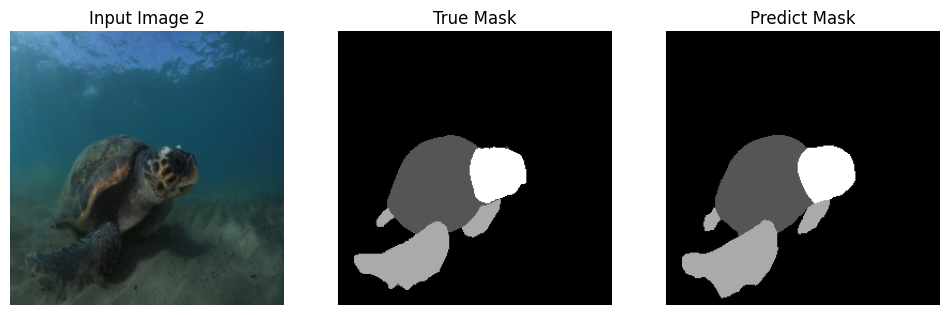

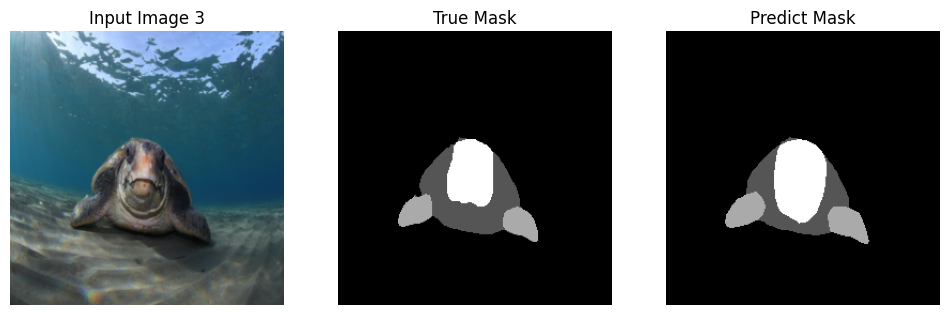

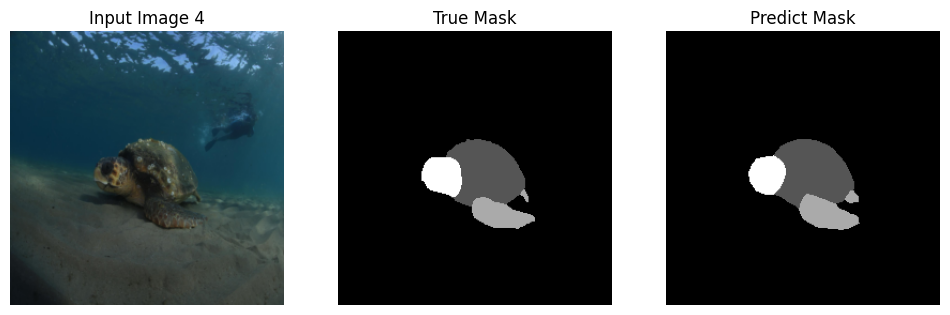

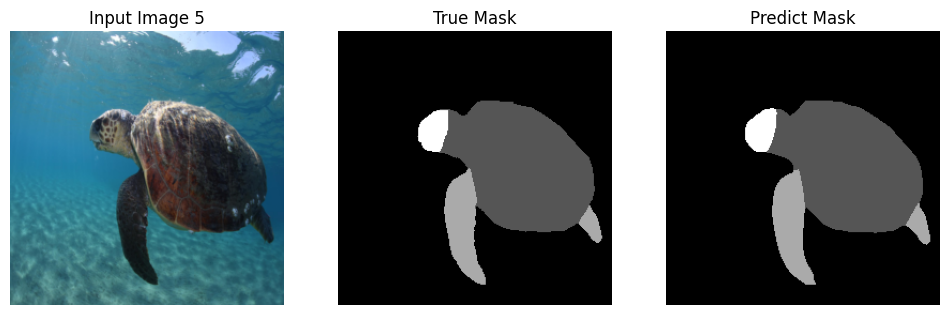

In [22]:
# Visualize the 5 images by IoU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
k= 5
k_images = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        outputs = model(images)['out']
        predictions = outputs.argmax(dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        # Calculate IoU for each image in the batch
        for i in range(images.size(0)):
            k_images.append((images[i].cpu(), masks[i], predictions[i]))


k_images = k_images[:k]
# Visualize the k images
for idx, (image, mask, prediction) in enumerate(k_images, 1):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"Input Image {idx}")
    plt.imshow(image.permute(1, 2, 0))  # Convert to HWC format
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predict Mask")
    plt.imshow(prediction, cmap='gray')
    plt.axis('off')

    plt.savefig(os.path.join(output_path, f"image_{idx}.png"))
    plt.show()